# Prompt Explorer

This is a notebook for exploring prompts and seeds. Random seeds are generated and displayed. The idea is to have this running alongside other more complicated notebooks, but this one doesn't needs to have gdrive connection. Then when finding cool prompt/seed combos, but them in the prompts google sheet and have those more complex notebooks reference the sheet vs defining prompts as variables in the code.

In [2]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/gdrive')

song_name = 'spacetrain' #@param {type:"string"}

code_folder = '/content/gdrive/MyDrive/AI-Art Lee'

fp = os.path.join(code_folder, 'input_data.xlsx')
df_prompt = pd.read_excel(fp, 'prompts_{}'.format(song_name), index_col=0).dropna(how='all')
df_prompt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


prompt  \
name                                                             
st_retroart  a train travelling through space, stars, retro...   
st_genre     a train travelling through space, stars, Genre...   
st_surreal   a train travelling through space, stars, Surre...   

                                                         seeds  guidance_scale  
name                                                                            
st_retroart  1251698433445435, 2287259771456094, 9195882365...             7.5  
st_genre     7513550102712487, 2019222925868596, 6484628732...             7.5  
st_surreal   6548786446951153, 6044285832786262, 8987207457...             7.5

In [3]:
%%capture
!pip install diffusers
!pip install transformers scipy ftfy accelerate

import torch
from diffusers import StableDiffusionPipeline

In [4]:

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                               torch_dtype=torch.float16,
                                               safety_checker=None
                                               )


pipe = pipe.to("cuda")

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

In [5]:
df_prompt = pd.read_excel(fp, 'prompts_{}'.format(song_name), index_col=0).dropna(how='all')
df_prompt.tail()

prompt  \
name                                                             
st_retroart  a train travelling through space, stars, retro...   
st_genre     a train travelling through space, stars, Genre...   
st_surreal   a train travelling through space, stars, Surre...   

                                                         seeds  guidance_scale  
name                                                                            
st_retroart  1251698433445435, 2287259771456094, 9195882365...             7.5  
st_genre     7513550102712487, 2019222925868596, 6484628732...             7.5  
st_surreal   6548786446951153, 6044285832786262, 8987207457...             7.5

Prompt: a floating tram, descending into an alien world, Matte Painting, retrowave color scheme, purple orange yellow maroon, full view of vehicle
Seeds: [645975170934172, 2651581993667215, 723867724183575, 8942706609879546, 5168016475448357, 6936096449585064, 3683556856703403, 6585761693116270]


  0%|          | 0/50 [00:00<?, ?it/s]

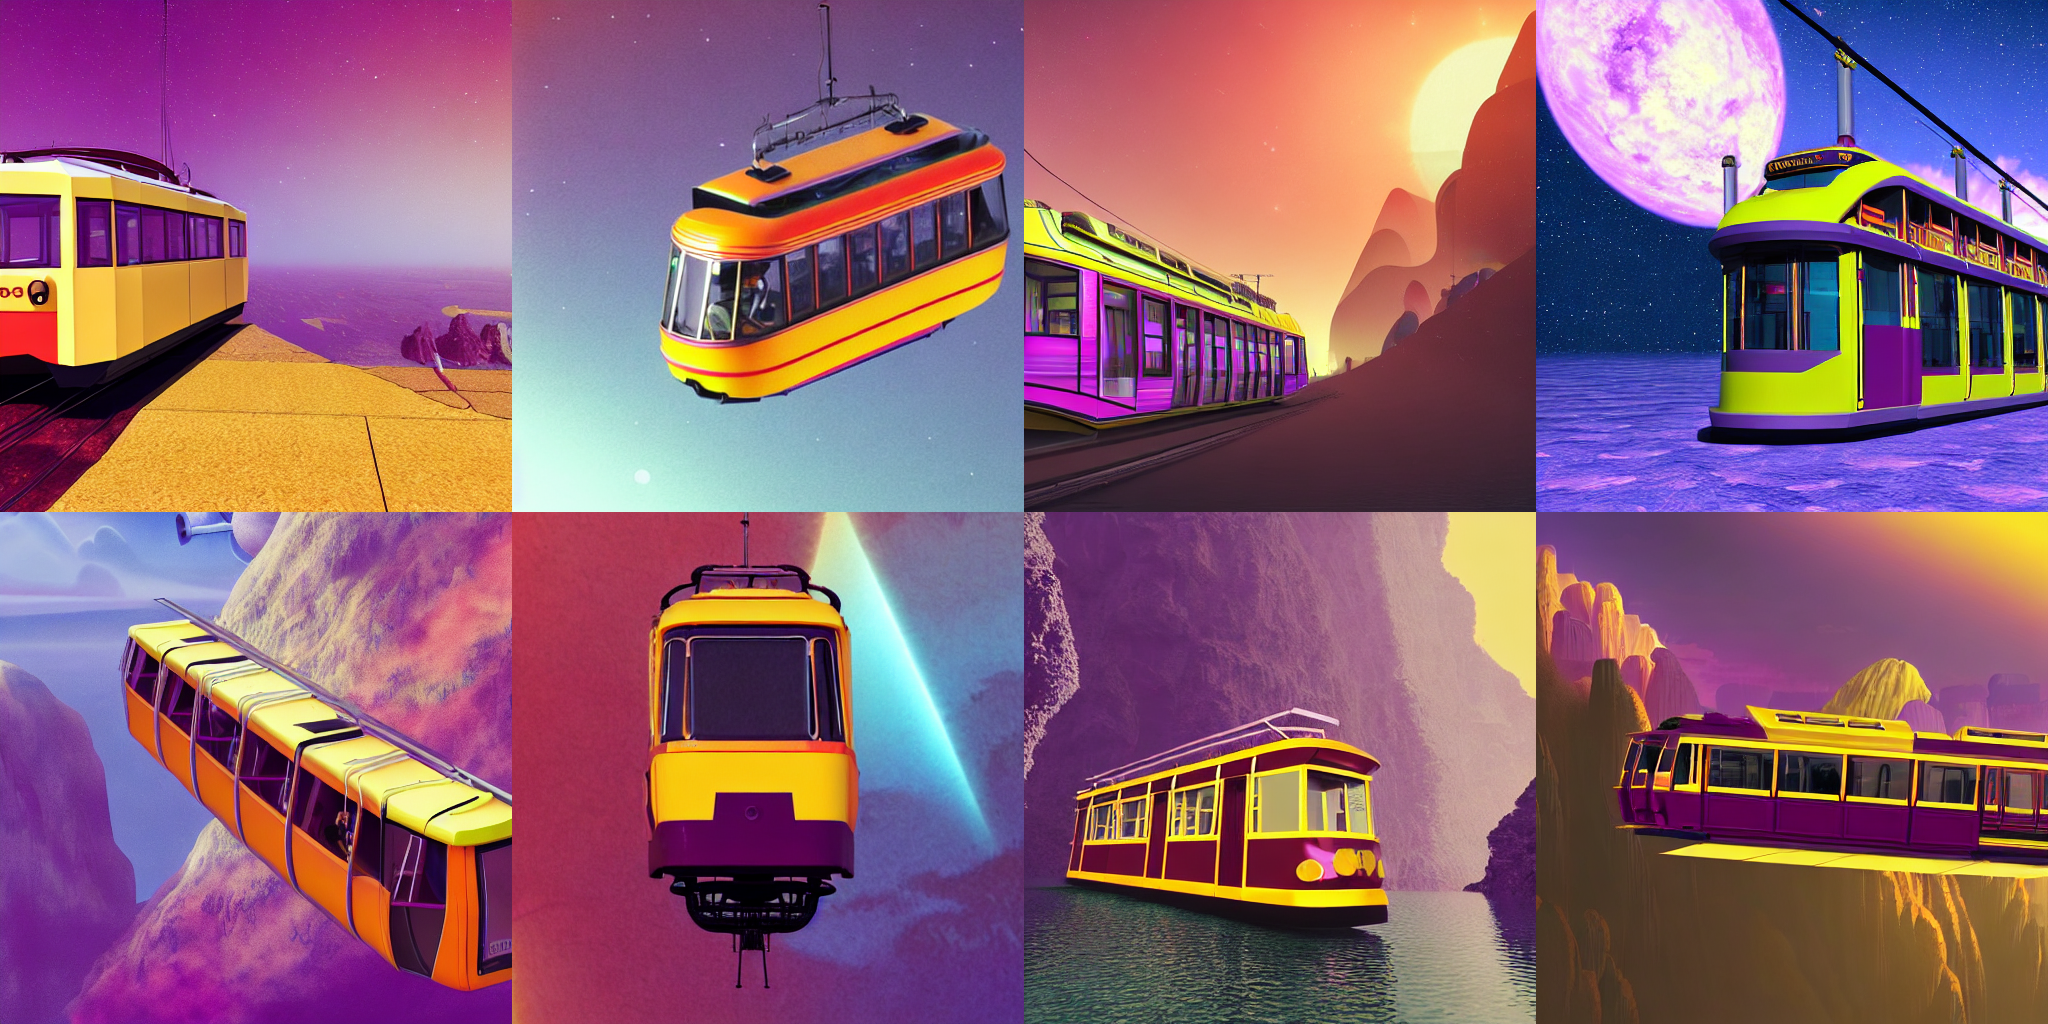

In [53]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


# # https://huggingface.co/docs/diffusers/using-diffusers/reusing_seeds

# prompt_name = 'spring forest2'
# prompt = df_prompt['prompt'][prompt_name]
# guidance_scale = float(df_prompt['guidance_scale'][prompt_name])


prompt_components = [
    "a floating tram",
    "descending into an alien world",
    "Matte Painting",
    "retrowave color scheme",
    "purple orange yellow maroon",
    "full view of vehicle",
]

prompt = ", ".join(prompt_components)

# rows X cols of images. Reduce for speed and memory issues.
rows = 2
cols = 4

num_images = rows*cols

# Make new random seeds in a hacky way. TODO: probably a function to generate seeds without making a generator instance.

generator = torch.Generator(device="cuda")
seeds = [generator.seed() for i in range(num_images)]
generator = [torch.Generator(device="cuda").manual_seed(seed) for seed in seeds]

print("Prompt: {}".format(prompt))
print("Seeds: {}".format(seeds))

images = pipe(prompt, generator=generator, num_images_per_prompt=rows*cols).images

image_grid(images, rows=rows, cols=cols)